## Posteriori Balancing Notebook
---

In this notebook we will focus on posteriori data balancing. This means that we focus on the extracted features, and we try to balance the data by using undersampling and oversampling techniques.

1. [Load Data](#Load-Data)
2. [Feature Distribution](#Feature-Distribution)
3. [Feature Balancing](#Feature-Balancing)

In [151]:
# import all the functions
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 1. Load Data <a id='Load-Data'></a>

In [152]:
# paths to the features and the labels
FEATURES_RAW_DIR = '../features/raw/'
FEATURES_PRIORI_BAL_DIR = '../features/balanced/priori/'
DIRS = [FEATURES_RAW_DIR, FEATURES_PRIORI_BAL_DIR]

FEATURES_POSTERIORI_BAL_DIR = '../features/balanced/posteriori/'

# properties of the data
frame_length = 1
sample_rate = 'mix'

#### 2. Feature Distribution <a id='Feature-Distribution'></a>

artifacts_base_1_mix.npz features   -   Label: 0.0
Max: 21160.455953663793, Min: -1131.369384765625, Mean: 483.97492510688136, Std: 1852.854843619321      -       Shape: (2000, 26)

extrastoles_base_1_mix.npz features   -   Label: 4.0
Max: 1057.6171875, Min: -309.2425537109375, Mean: 37.46883951805036, Std: 130.15941934366995      -       Shape: (247, 26)

extrahls_base_1_mix.npz features   -   Label: 1.0
Max: 18953.178879310344, Min: -674.0330810546875, Mean: 753.7483613723052, Std: 2587.231366594324      -       Shape: (124, 26)

murmurs_base_1_mix.npz features   -   Label: 2.0
Max: 13025.607825969828, Min: -574.7505493164062, Mean: 105.72155305406422, Std: 538.6539669046897      -       Shape: (1149, 26)

normals_base_1_mix.npz features   -   Label: 3.0
Max: 16976.08432112069, Min: -654.86279296875, Mean: 111.12140859068722, Std: 738.1790744503893      -       Shape: (2161, 26)



normals_1_mix.npz features   -   Label: 3.0
Max: 16976.08432112069, Min: -654.8628540039062, Mean: 111.

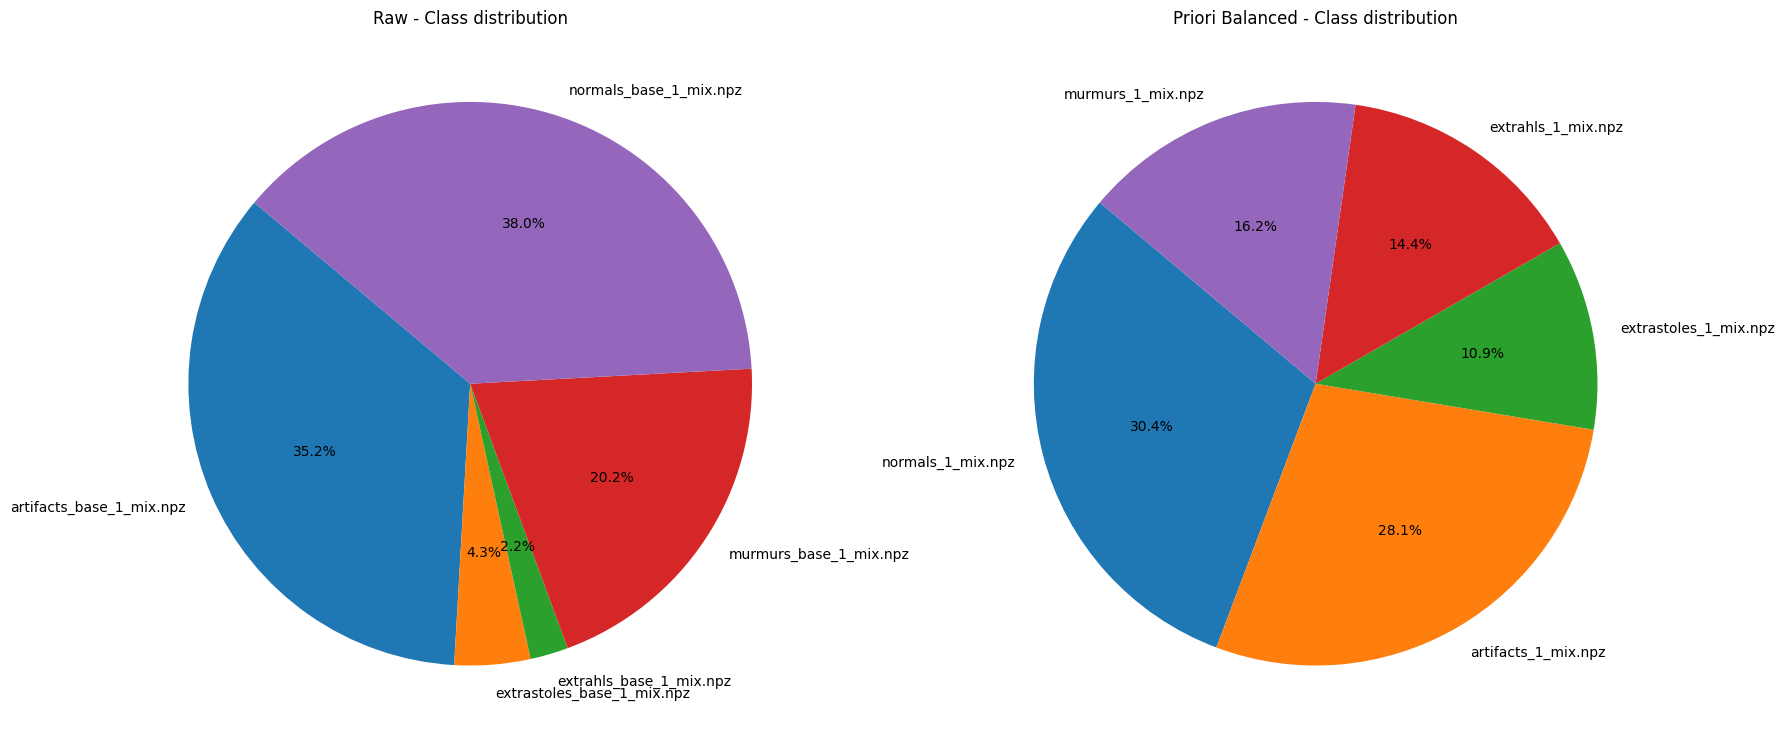

In [153]:
# basics statistics
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
titles = ['Raw', 'Priori Balanced']

for i, DIR in enumerate(DIRS):
	names = os.listdir(DIR)
	shapes = []
	name_labels = {}

	for name in names:
		features = np.load(DIR + name)['X']
		label = np.load(DIR + name)['y'][0]
		name_labels[name] = label
		max = features.max()
		min = features.min()
		mean = features.mean()
		std = features.std()
		print(f'{name} features   -   Label: {label}')
		print(f'Max: {max}, Min: {min}, Mean: {mean}, Std: {std}      -       Shape: {features.shape}\n')
		shapes.append(features.shape[0])

	print('\n')
	title = titles[i]
	axs[i].pie(shapes, labels = name_labels.keys(), autopct='%1.1f%%', startangle=140)
	axs[i].set_title(f'{title} - Class distribution')

#### 3. Feature Balancing <a id='Feature-Balancing'></a>

To address the problem of class imbalance, we have different options:
- **Undersampling**: randomly remove samples from the majority class. However the high difference in the number of samples between classes may lead to a loss of information. This approach may be viable, reducing the frame window size, to enlarge the number of samples in the minority class. We skip this approach for now.
- **Classic Oversampling**: randomly duplicate samples from the minority class. This approach may lead to overfitting, as the model may learn the same samples multiple times. We skip this approach for now.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: generate synthetic samples from the minority class. This approach may be more robust than the classic oversampling, as it generates new samples based on the existing ones. We will use this approach to balance the classes.

In [154]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTEN
from collections import Counter

# --------------------------------------------------------------------
# --------------------------------------------------------------------


def rebalance_data(data_to_balance, target_size, random_seed):
    """
    Rebalances the data by oversampling or undersampling the classes based on the target size.
     
    Parameters:
    - data_to_balance: Numpy array representing the data to be rebalanced (X,y,filename).
    - target_size (int): The desired size for each class after rebalancing.
    - random_seed (int): The random seed for reproducibility.
    
    Returns:
    - data_rebalanced: Rebalanced data, where data element is a numpy array.
    """
    
    # Extract the data and the labels
    X = data_to_balance[:,:-2]
    y = data_to_balance[:,-2]
    filenames = data_to_balance[:,-1]
    
    X = np.hstack((X, filenames.reshape(-1,1)))
    
    # Get the unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    # check the classes to be undersampled or oversampled
    classes_to_undersample = unique_classes[class_counts > target_size]
    classes_to_oversample = unique_classes[class_counts < target_size]
    
    # Initialize the undersampler and oversampler
    undersampler = RandomUnderSampler(sampling_strategy={class_: target_size for class_ in classes_to_undersample}, random_state=random_seed)
    oversampler = SMOTEN(sampling_strategy={class_: target_size for class_ in classes_to_oversample}, random_state=random_seed)
    
    # get the data to be undersampled
    X_to_undersample = X[np.isin(y, classes_to_undersample)]
    X_to_oversample = X[np.isin(y, classes_to_oversample)]
    
    # get the labels to be undersampled
    y_to_undersample = y[np.isin(y, classes_to_undersample)]
    y_to_oversample = y[np.isin(y, classes_to_oversample)]
    
    # undersample the data
    X_undersampled, y_undersampled = undersampler.fit_resample(X_to_undersample, y_to_undersample)
    X_oversampled, y_oversampled = oversampler.fit_resample(X_to_oversample, y_to_oversample)
    
    # detach the filenames
    filenames_undersampled = X_undersampled[:,-1]
    filenames_oversampled = X_oversampled[:,-1]
    
    # remove the filenames from the data
    X_undersampled = X_undersampled[:,:-1]
    X_oversampled = X_oversampled[:,:-1]
    
    # concatenate the data
    data_oversampled = np.hstack((X_oversampled, y_oversampled.reshape(-1,1), filenames_oversampled.reshape(-1,1)))
    data_undersampled = np.hstack((X_undersampled, y_undersampled.reshape(-1,1), filenames_undersampled.reshape(-1,1)))
    full_data = np.vstack((data_oversampled, data_undersampled))
    
    return full_data
    
    
    
# --------------------------------------------------------------------
# --------------------------------------------------------------------

In [155]:
# load all the priori balanced features
full_data_tmp = []
s = 0

for name in os.listdir(FEATURES_PRIORI_BAL_DIR):
    features = np.load(FEATURES_PRIORI_BAL_DIR + name)['X']
    label = np.load(FEATURES_PRIORI_BAL_DIR + name)['y']
    filename = np.load(FEATURES_PRIORI_BAL_DIR + name)['filename']
    array = np.hstack((features, label.reshape(-1, 1), filename.reshape(-1, 1)))
    full_data_tmp.append(array)
    s += features.shape[0]

# create a unique array with all the features
full_data = np.vstack(full_data_tmp)

# divide the data into features and labels
X = full_data[:, :-2]
y = full_data[:, -2]
filename = full_data[:, -1]

# split the data into training and testing
X_train, X_test, y_train, y_test, filename_train, filename_test = train_test_split(X, y, filename, test_size=0.2, random_state=42, stratify=y)

# attach filename and label to the features
train = np.hstack((X_train, y_train.reshape(-1, 1), filename_train.reshape(-1, 1)))
test = np.hstack((X_test, y_test.reshape(-1, 1), filename_test.reshape(-1, 1)))

# balance the training data
train_balanced = rebalance_data(train, target_size = 1500, random_seed = 42)

# check the train_balanced data
print(f'Original training data shape: {train.shape}')
print(f'Balanced training data shape: {train_balanced.shape}')

Original training data shape: (5690, 28)
Balanced training data shape: (7500, 28)


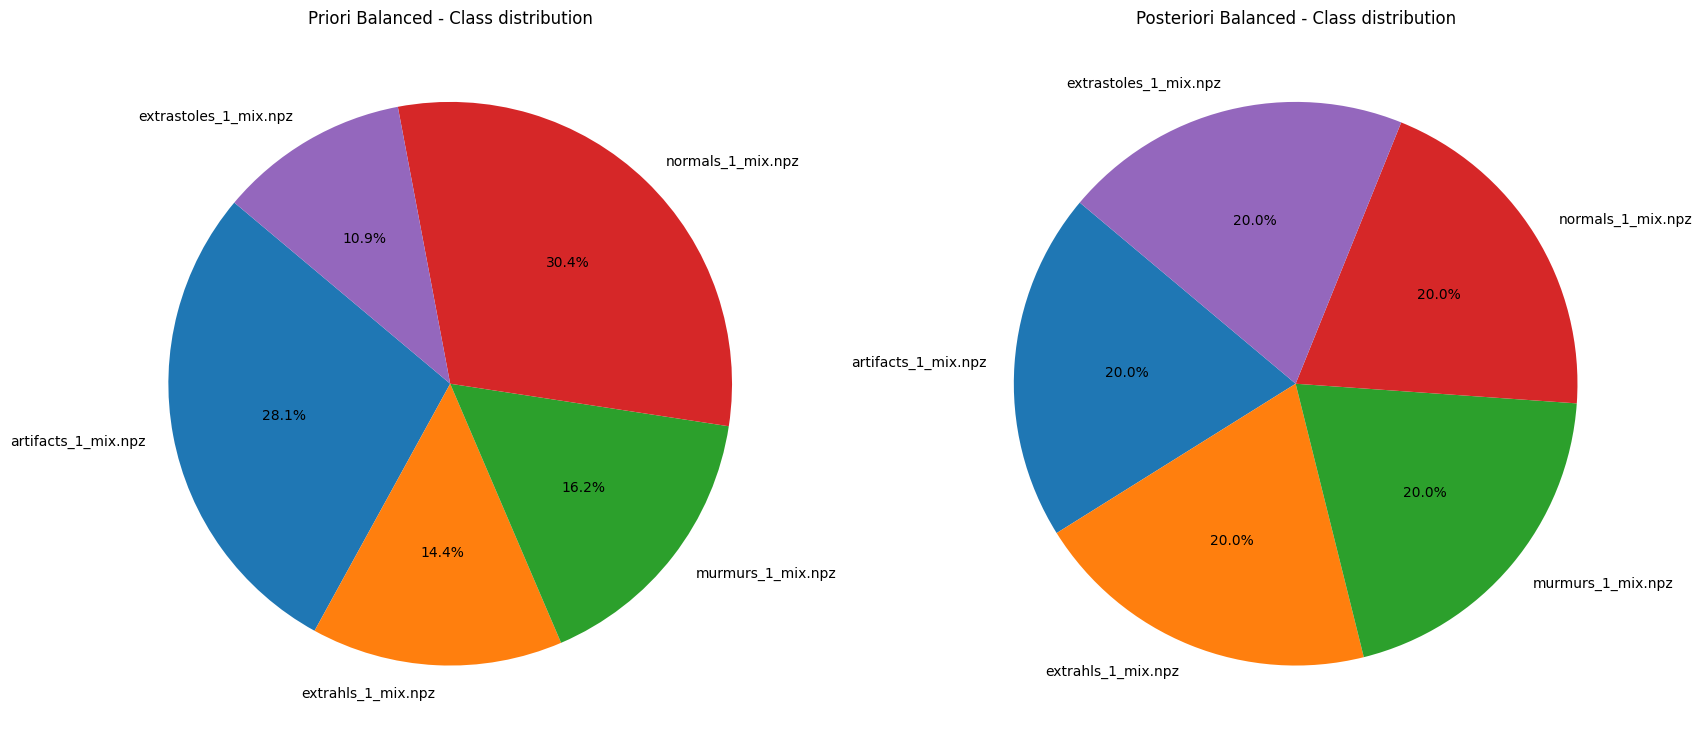

In [156]:
# revert the name_labels dictionary
name_labels_reverse = {v: k for k, v in name_labels.items()}
labels = []
unique_classes = np.unique(train[:,-2])
for class_ in unique_classes:
    labels.append(name_labels_reverse[class_])

# pie chart priori vs posteriori balanced
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
titles = ['Priori Balanced', 'Posteriori Balanced']

for i, data in enumerate([train, train_balanced]):
    unique_classes, class_counts = np.unique(data[:,-2], return_counts=True)
    title = titles[i]
    axs[i].pie(class_counts, labels = labels, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(f'{title} - Class distribution')


In [157]:
# create a dictionary to save the data
train_bal = {}
train_bal['X'] = train_balanced[:, :-2]
train_bal['y'] = train_balanced[:, -2]
train_bal['filename'] = train_balanced[:, -1]

train_unb = {}
train_unb['X'] = train[:, :-2]
train_unb['y'] = train[:, -2]
train_unb['filename'] = train[:, -1]

test_dict = {}
test_dict['X'] = test[:, :-2]
test_dict['y'] = test[:, -2]
test_dict['filename'] = test[:, -1]

# aggregate the dictionary into another dictionary
full_data = {}
full_data['train_unb'] = train_unb
full_data['train_bal'] = train_bal
full_data['test'] = test_dict

# save the data
NAME = 'full_data.npy'
np.save(FEATURES_POSTERIORI_BAL_DIR + f'full_data_{frame_length}_{sample_rate}.npy', full_data)

In [158]:
# load the data
full_data = np.load(FEATURES_POSTERIORI_BAL_DIR + f'full_data_{frame_length}_{sample_rate}.npy', allow_pickle=True).item()

# check the data
print(full_data.keys())
print(full_data['train_unb'].keys())
print(full_data['train_bal'].keys())
print(full_data['test'].keys())

# check the data shape
print(full_data['train_unb']['X'].shape)
print(full_data['train_bal']['X'].shape)
print(full_data['test']['X'].shape)

dict_keys(['train_unb', 'train_bal', 'test'])
dict_keys(['X', 'y', 'filename'])
dict_keys(['X', 'y', 'filename'])
dict_keys(['X', 'y', 'filename'])
(5690, 26)
(7500, 26)
(1423, 26)
